🔥 Using device: cuda
Loaded 2333 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Predicting: 100%|██████████| 2333/2333 [01:34<00:00, 24.79it/s]



🎯 Accuracy: 0.712

Classification Report:

              precision    recall  f1-score   support

    negative      0.840     0.100     0.179       419
     neutral      0.152     0.167     0.159       222
    positive      0.776     0.935     0.848      1692

    accuracy                          0.712      2333
   macro avg      0.589     0.401     0.395      2333
weighted avg      0.728     0.712     0.662      2333



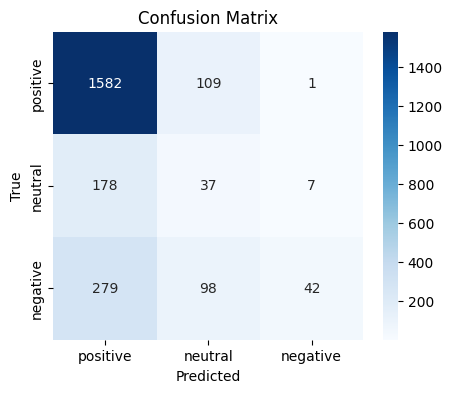

In [ ]:

import pandas as pd, numpy as np, torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- 1. Check for GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 2. Load data ---
df = pd.read_csv("data/split/test_split.csv")   # must have columns: text, label
df["label"] = df["label"].str.lower().str.strip()
print(f"Loaded {len(df)} samples")

# --- 3. Load model ---
tok = AutoTokenizer.from_pretrained("bert-base-uncased")
mlm = AutoModelForMaskedLM.from_pretrained("bert-base-uncased").to(device)
mlm.eval()

# --- 4. Verbalizers & templates ---
VERBALIZERS = {
    "positive": ["great","excellent","amazing","good","pleasant","satisfied"],
    "neutral":  ["okay","average","fine","mediocre","neutral","so-so"],
    "negative": ["terrible","awful","bad","poor","horrible","disappointed"]
}

TEMPLATES = [
    "{text} Overall, this review is [MASK].",
    "{text} In summary, the sentiment is [MASK].",
    "{text} The experience was [MASK]."
]

# --- 5. Prediction (GPU aware) ---
@torch.no_grad()
def predict_sentiment(text):
    scores_sum = {k: 0.0 for k in VERBALIZERS}
    for tmpl in TEMPLATES:
        s = tmpl.format(text=text.strip())
        enc = tok(s, return_tensors="pt", truncation=True, max_length=256).to(device)
        mask_pos = (enc["input_ids"] == tok.mask_token_id).nonzero(as_tuple=False)
        if mask_pos.numel() == 0:
            continue
        logits = mlm(**enc).logits
        idx = mask_pos[-1,1].item()
        probs = torch.softmax(logits[0, idx], dim=-1)
        for label, words in VERBALIZERS.items():
            ids = tok.convert_tokens_to_ids(words)
            scores_sum[label] += float(probs[ids].sum().item())
    total = sum(scores_sum.values())
    if total == 0: return "neutral"
    for k in scores_sum:
        scores_sum[k] /= total
    return max(scores_sum, key=scores_sum.get)

# --- 6. Predict all ---
preds = []
for t in tqdm(df["text"], desc="Predicting"):
    preds.append(predict_sentiment(t))
df["pred"] = preds

# --- 7. Evaluate ---
y_true, y_pred = df["label"], df["pred"]
print("\nAccuracy:", round(accuracy_score(y_true, y_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# --- 8. Confusion Matrix ---
labels = ["positive","neutral","negative"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


🔥 Device: cuda


d:\学校软件\oned\OneDrive - Ngee Ann Polytechnic\Desktop\BT4222Project\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Loaded 2333 samples


Predicting: 100%|██████████| 2333/2333 [03:51<00:00, 10.08it/s]



🎯 Accuracy: 0.6764

Classification Report:

              precision    recall  f1-score   support

    negative      0.077     0.002     0.005       419
     neutral      0.140     0.176     0.156       222
    positive      0.753     0.909     0.824      1692

    accuracy                          0.676      2333
   macro avg      0.323     0.362     0.328      2333
weighted avg      0.573     0.676     0.613      2333



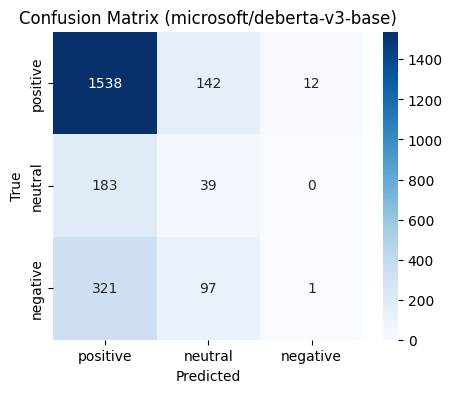

In [ ]:
# =====================================================
# Zero-Fine-Tuning Sentiment Analysis (DeBERTa / BERT)
# =====================================================
!pip install -q transformers torch pandas scikit-learn matplotlib tqdm seaborn

import pandas as pd, numpy as np, torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -------------------------------
# 1.  Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Choose model here
MODEL_NAME = "microsoft/deberta-v3-base"   # or "bert-base-uncased"
MAX_LEN = 256

# Load model + tokenizer
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
mlm = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
mlm.eval()

# -------------------------------
# 2. Load dataset
# -------------------------------
df = pd.read_csv("data/split/test_split.csv")   # must have columns: text, label
df["label"] = df["label"].str.lower().str.strip()
print(f"Loaded {len(df)} samples")

# -------------------------------
# 3. Define verbalizers & templates
# -------------------------------
VERBALIZERS = {
    "positive": ["great","excellent","amazing","good","pleasant","satisfied"],
    "neutral":  ["okay","average","fine","mediocre","neutral","so-so"],
    "negative": ["terrible","awful","bad","poor","horrible","disappointed"]
}

TEMPLATES = [
    "{text} Overall, this review is [MASK].",
    "{text} In summary, the sentiment is [MASK].",
    "{text} The experience was [MASK]."
]

# -------------------------------
# 4. Prediction function
# -------------------------------
@torch.no_grad()
def predict_sentiment(text):
    scores_sum = {k: 0.0 for k in VERBALIZERS}
    for tmpl in TEMPLATES:
        s = tmpl.format(text=text.strip())
        enc = tok(s, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
        mask_pos = (enc["input_ids"] == tok.mask_token_id).nonzero(as_tuple=False)
        if mask_pos.numel() == 0:
            continue
        logits = mlm(**enc).logits
        idx = mask_pos[-1,1].item()
        probs = torch.softmax(logits[0, idx], dim=-1)
        for label, words in VERBALIZERS.items():
            ids = tok.convert_tokens_to_ids(words)
            scores_sum[label] += float(probs[ids].sum().item())
    total = sum(scores_sum.values())
    if total == 0: return "neutral"
    for k in scores_sum: scores_sum[k] /= total
    return max(scores_sum, key=scores_sum.get)

# -------------------------------
# 5. Run predictions
# -------------------------------
preds = []
for text in tqdm(df["text"], desc="Predicting"):
    preds.append(predict_sentiment(text))
df["pred"] = preds

# -------------------------------
# 6. Evaluate
# -------------------------------
y_true, y_pred = df["label"], df["pred"]
print("\nAccuracy:", round(accuracy_score(y_true, y_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ({MODEL_NAME})")
plt.show()
